<img src="http://www.finanze.gov.it/export/system/modules/it.gov.finanze.template/resources/img/logo-mef.gif"  style="float: left; width: 25%; margin-left: 8%; margin-top: 0.5em;">

<img src="http://www.opencoesione.gov.it/static/img/header/testata.png" style="float: right; width: 42%; margin-right: 8%; margin-top: 1.6em;">

<p style="clear: both;">

# Studio a livello comunale sui finanziamenti a enti privati da dati OpenCoesione

### Obiettivi 
Questo studio si propone come esempio delle seguenti opportunita' offerte dal Data Analytics Framework (DAF):
 - Integrare dati da fonti diverse permette di compiere analisi piu' complete e semplici
 - L'uso di strumenti open-source consente di impiegare le piu' recenti ed avanzate tecniche di analisi ...

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc #garbage collector
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,12)


## Caricamento dataset da integrare

In [2]:
# --- Spese e redditi da OpenCivitas
speseERedditiComune = pd.read_csv('../opencivitas/data/opencivitas_spesa_storica_dati_irpef.csv') #dati per anno

provToRegioni = pd.read_csv('../provToReg.csv', dtype='str', index_col='Sigla automobilistica')
speseERedditiComune = speseERedditiComune[~speseERedditiComune['Codice Istat Comune'].isna()]
speseERedditiComune = pd.merge(
    speseERedditiComune, provToRegioni, how='left', left_on='Provincia', right_index=True)

padZeros = np.vectorize(lambda x: str(x).rjust(6, '0')) # some utils

speseERedditiComune['Codice Istat Lungo'] = \
(speseERedditiComune['Codice regione'] + padZeros(speseERedditiComune['Codice Istat Comune'].astype(int))).astype(int)

# --- Soggetti e luoghi da OpenCoesione
soggettiLuoghi = pd.read_csv('../pac_opencoesione/SoggettiELuoghi.csv', low_memory=False)
soggettiLuoghi.drop(columns=['SOGG_COD_RUOLO', 'SOGG_PROGR_RUOLO'], inplace=True)
soggettiLuoghi = soggettiLuoghi[~soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.isna()]
assert not any(soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].isna()), 'Unexpected missing codes'
soggettiLuoghi['COD_COMUNE_SEDE_SOGG'] = soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].astype(int)
soggettiLuoghi['COD_COMUNE_LUOGO'] = soggettiLuoghi['COD_COMUNE_LUOGO'].fillna(value=-1).astype(int)

## Integrazione OpenCoesione and OpenCivitas

In [3]:
# --- Anagrafica Comuni
path_comuni = '../pac_agenziaentrate/regioni_citta/comuni/archivio_comuni/ElencoComuniAttuali_20170918.csv.read'

comuniAnagrafica = pd.read_csv(path_comuni, sep=';')
comuniAnagrafica.set_index('Codice Istat', inplace=True)
comuniAnagrafica = comuniAnagrafica[~comuniAnagrafica.index.isnull()]
assert not any(comuniAnagrafica.index.duplicated()), 'Duplicate Istat codes'
convTable = pd.read_csv('../provToReg.csv', index_col='Sigla automobilistica', dtype='str')
comuniAnagrafica = comuniAnagrafica.join(convTable, on='Sigla Provincia')
formattedValues = comuniAnagrafica.index.values.astype('int')
padZeros = np.vectorize(lambda x: str(x).rjust(6, '0'))
comuniAnagrafica['Codice Istat Lungo'] = (comuniAnagrafica['Codice regione'] + padZeros(formattedValues)).astype(int)

#### Estrazione fondi erogati a soggetti privati per cui la sede e' riferibile ad un Comune:

In [4]:
bEntePrivato = soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.str.startswith('1') & \
                    (soggettiLuoghi.COD_COMUNE_SEDE_SOGG != -1)
soggLuoghiPrivato = soggettiLuoghi[bEntePrivato]

# luoghi (comuni) di sede soggetto in ordine di fondi ricevuti
fondiSoggetti = soggLuoghiPrivato.groupby(
                    'COD_COMUNE_SEDE_SOGG')['TOT_PAGAMENTI'].sum().sort_values(ascending=False).to_frame()

fondiSoggetti = fondiSoggetti[fondiSoggetti >0]
print(fondiSoggetti.head(10))
print(fondiSoggetti.sum())

                      TOT_PAGAMENTI
COD_COMUNE_SEDE_SOGG               
12058091               6.926394e+09
3015146                8.531263e+08
15063049               3.882678e+08
19082053               3.485534e+08
18078045               3.253154e+08
16072006               3.067115e+08
16071024               2.988484e+08
9048017                2.979771e+08
7010025                2.316785e+08
15064065               2.000012e+08
TOT_PAGAMENTI    1.359484e+10
dtype: float64


#### In OpenCivitas non vi sono dati per tutti i Comuni, controlliamo quanto e' grande la quota di fondi in OpenCoesione riferita a sedi soggetto mancanti in OpenCivitas

In [5]:
listaComuniOpenCiv = speseERedditiComune['Codice Istat Lungo'].drop_duplicates()

print('''Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR %.4g, 
            di cui %.4g corrispondono a comuni in OpenCivitas) ''' % (fondiSoggetti.sum(),
                fondiSoggetti[fondiSoggetti.index.isin(listaComuniOpenCiv.values)].sum()))

unioneComuniSoggetti = pd.merge(speseERedditiComune, fondiSoggetti,
                                how='left',left_on='Codice Istat Lungo', right_index = True)

b2013 = unioneComuniSoggetti.ANNO==2013

Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR 1.359e+10, 
            di cui 1.222e+10 corrispondono a comuni in OpenCivitas) 


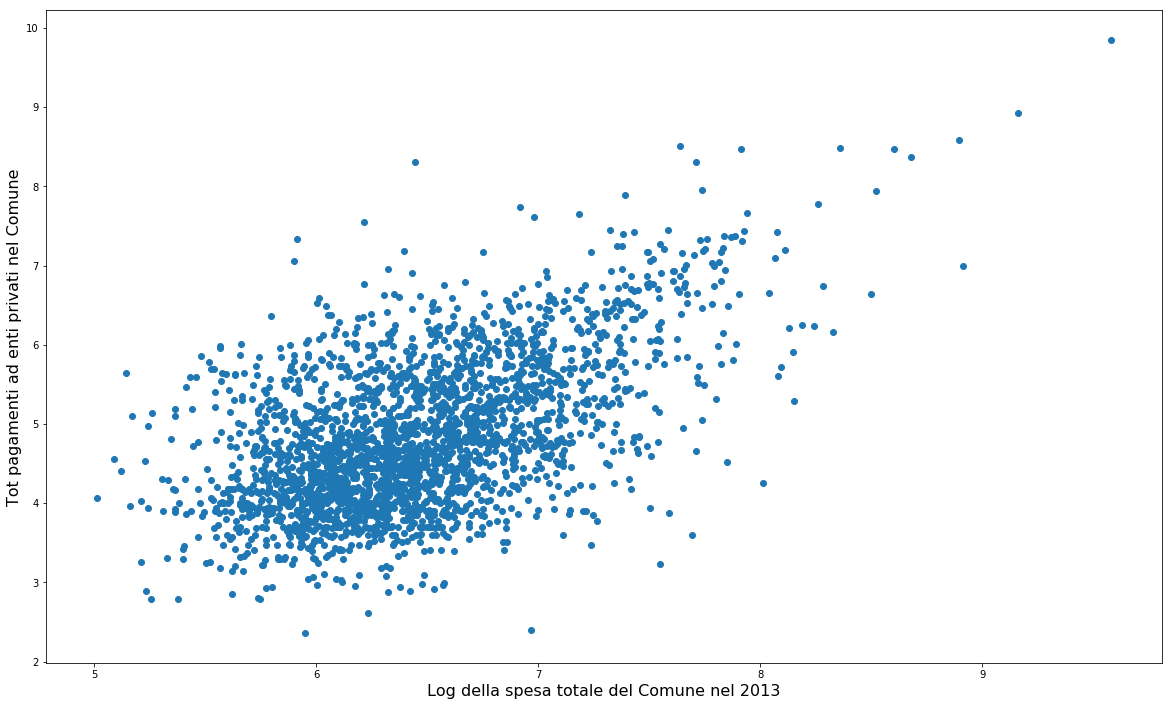

In [12]:
plt.scatter(np.log10(unioneComuniSoggetti[b2013].SPESA_CCC_tot), np.log10(unioneComuniSoggetti[b2013].TOT_PAGAMENTI))
plt.xlabel('Log della spesa totale del Comune nel 2013', size=16)
plt.ylabel('Tot pagamenti ad enti privati nel Comune', size=16)
plt.show()



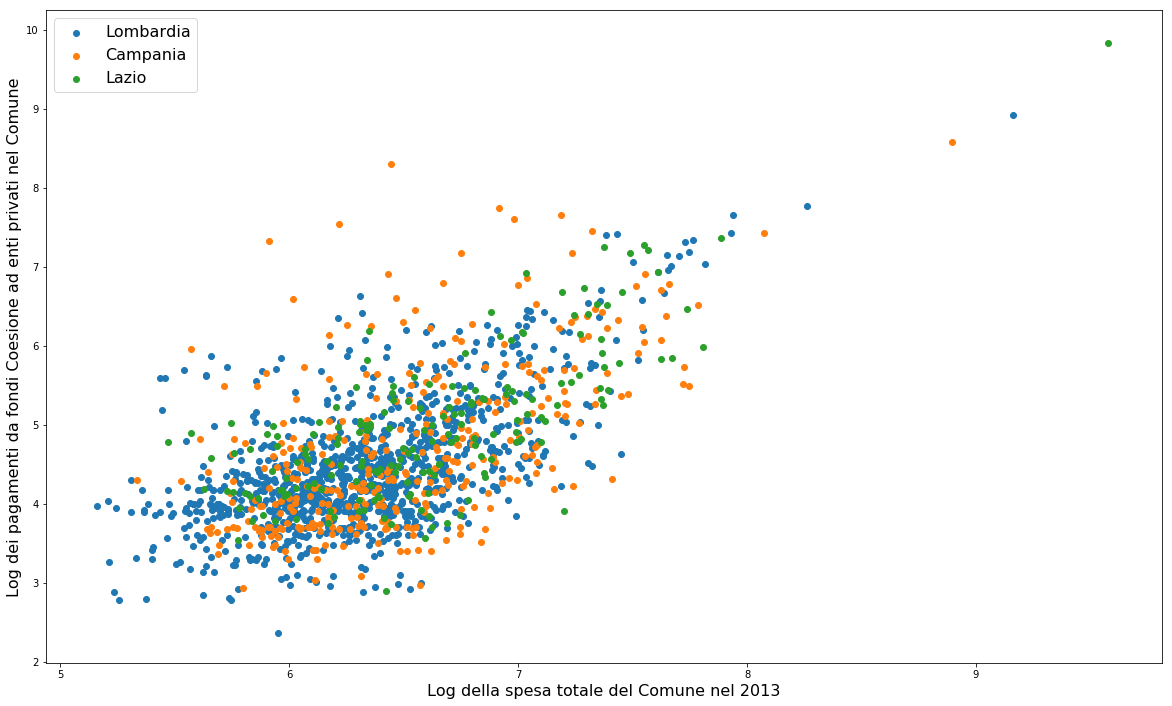

In [13]:
for regCode in ['03','15','12']:
    data = unioneComuniSoggetti[b2013 & unioneComuniSoggetti['Codice regione'].isin([regCode])]
    plt.scatter(np.log10(data['SPESA_CCC_tot']), np.log10(data['TOT_PAGAMENTI'])) #c=data['Codice regione'].astype(int)
plt.xlabel('Log della spesa totale del Comune nel 2013', size=16)
plt.ylabel('Log dei pagamenti da fondi Coesione ad enti privati nel Comune', size=16)
plt.legend(['Lombardia', 'Campania', 'Lazio'], fontsize=16)
plt.show()

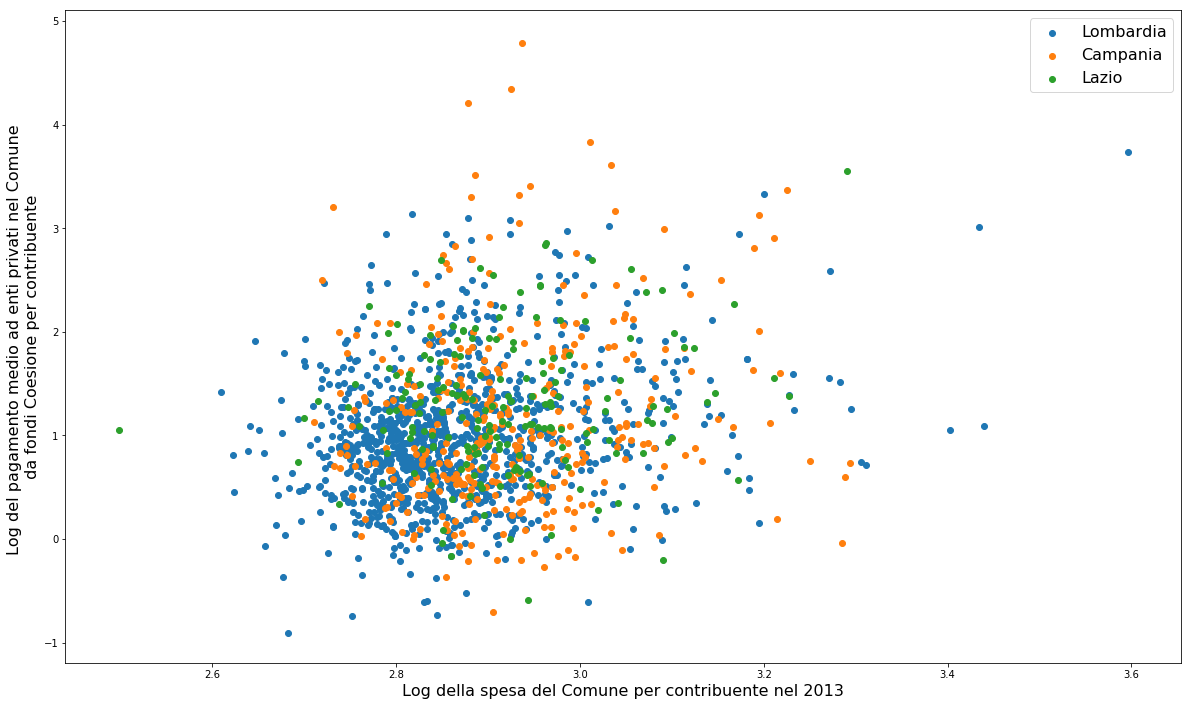

In [15]:
data = unioneComuniSoggetti[b2013]
for regCode in ['03','15','12']:
    data = unioneComuniSoggetti[b2013 & unioneComuniSoggetti['Codice regione'].isin([regCode])]
    plt.scatter(np.log10(data['SPESA_CCC_tot']/data['Numero contribuenti']), 
                np.log10(data['TOT_PAGAMENTI']/data['Numero contribuenti']))#c=data['Codice regione'].astype(int)
plt.xlabel('Log della spesa del Comune per contribuente nel 2013', size=16)
plt.ylabel('Log del pagamento medio ad enti privati nel Comune \n da fondi Coesione per contribuente ', size=16)
plt.legend(['Lombardia', 'Campania', 'Lazio'], fontsize=16)
plt.show()